In [1]:
# import pytorch
import torch
from torch import nn

# torchvision imports
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#matplotlib
import matplotlib.pyplot as plt


In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 247214014.07it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105703048.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82000135.13it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 998403.06it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_data,test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

image.shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

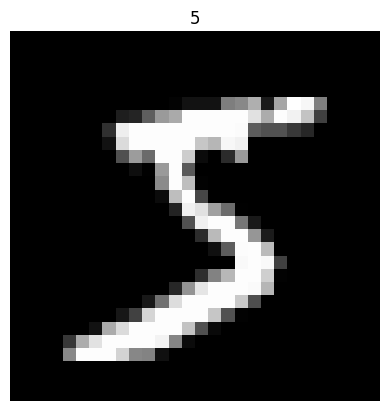

In [5]:
# Visualizing the first image
image,label = train_data[0]
print(f"image.shape: {image.shape}")
plt.imshow(image.squeeze(),cmap="gray") # cmap='gray' for grayscale so image appears in black and white
plt.axis('Off')
plt.title(label)

# Using DataLoader

Using DataLoader to help load data into model via batches

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #This means that in each epoch, the order of the training examples will be different

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


In [7]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
## Version 1 of Digit Recognizer: without convolutional layers only Linear layers(Fully connected) and non-linear(ReLU)
class DigitRecognizerV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int,output_shape:int) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten image into 1d vector
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x:torch.Tensor):
    return self.layer_stack(x)

In [9]:
torch.manual_seed(50) #ensure Reproducibility
model_0 = DigitRecognizerV1(input_shape=784, # 28 * 28 height * width of image
                            hidden_units=16,
                            output_shape=len(class_names)).to(device) # number of labels
next(model_0.parameters()).device # checking device of model 0 object

device(type='cuda', index=0)

### Loss Function and Optimizer

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=.1) # using stochastic gradient descent for optimizer

### Creating a timer function using timeit defualt timer(not needed but nice to see)

In [11]:
from timeit import default_timer as d_timer

def train_time(start: float, end: float):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time: {total_time:.3f} seconds")
    return total_time

In [12]:
def accuracy_fn(actual_labels, pred_labels):
    """Calculates accuracy between actual labels and prediction labels.

    Args:
        actual_labels (torch.Tensor): Actual labels from the dataset, in other words the "correct answer".
        pred_labels (torch.Tensor): Predictions to be compared to actual labels.

    Returns:
        [torch.float]: Accuracy value between actual_labels and pred_labels
    """
    correct = torch.eq(actual_labels, pred_labels).sum().item()
    return (correct / len(pred_labels)) * 100


In [13]:
def train_batches(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X,y) in enumerate(data_loader):
    #send data on GPU if GPU is available
    X,y = X.to(device), y.to(device)


    #forward pass
    pred_labels = model(X)

    # Loss Calculation
    loss = loss_fn(pred_labels,y)
    train_loss += loss
    train_acc += accuracy_fn(actual_labels=y,
                pred_labels=pred_labels.argmax(dim=1)) #take raw output(logits) and convert to pred probabilities

    optimizer.zero_grad()

    # backpropogation and gradient descent (updating weights and biases)
    loss.backward()
    optimizer.step()
  #loss and accuracy per epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



def test_batches(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  test_loss, test_acc = 0,0
  model.to(device)
  model.eval() #put model on eval mode since its on train mode by default
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred,y)
      test_acc += accuracy_fn(actual_labels=y,
                              pred_labels=test_pred.argmax(dim=1)) #logits to pred probs
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


# Training Loop

In [14]:
from tqdm.auto import tqdm #provides a nice looking progress bar for iterables (optional)
torch.manual_seed(50)

epochs = 5
start_time = d_timer() # Record start time
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_batches(model=model_0,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn)

  test_batches(model=model_0,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn)
end_time = d_timer() # Record end time
train_time(start=start_time,
           end=end_time)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64550 | Train accuracy: 79.58%
Test loss: 0.47600 | Test accuracy: 83.73%

Epoch: 1
---------
Train loss: 0.47247 | Train accuracy: 83.76%
Test loss: 0.44452 | Test accuracy: 84.44%

Epoch: 2
---------
Train loss: 0.44095 | Train accuracy: 84.58%
Test loss: 0.45226 | Test accuracy: 84.03%

Epoch: 3
---------
Train loss: 0.36065 | Train accuracy: 87.67%
Test loss: 0.20253 | Test accuracy: 94.34%

Epoch: 4
---------
Train loss: 0.19945 | Train accuracy: 94.33%
Test loss: 0.17522 | Test accuracy: 95.08%

Train time: 83.185 seconds


83.184791083

In [15]:
def make_preds(model: torch.nn.Module,data:list,device: torch.device = device):
  pred_probs = []
  model.eval()# turn on eval mode
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device) #add an extra dimension to sample data

      #forward pass
      pred_raw = model(sample) # raw logits

      pred_prob = torch.softmax(pred_raw.squeeze(),dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

      pred_probs.append(pred_prob.cpu()) # get pred_prob of gpu if it is on gpu
  return  torch.stack(pred_probs)

In [16]:
import random
test_samps = []
test_labs = []
for sample, label in random.sample(list(test_data), k=6):
  test_samps.append(sample)
  test_labs.append(label)
test_samps[0].shape # verifying shape of first sample

torch.Size([1, 28, 28])

In [17]:
#use make predictions helper function to make predictions on samples
pred_probs = make_preds(model_0,test_samps)
# going for pred probabilities to prediction labels
pred_labels = pred_probs.argmax(dim=1)

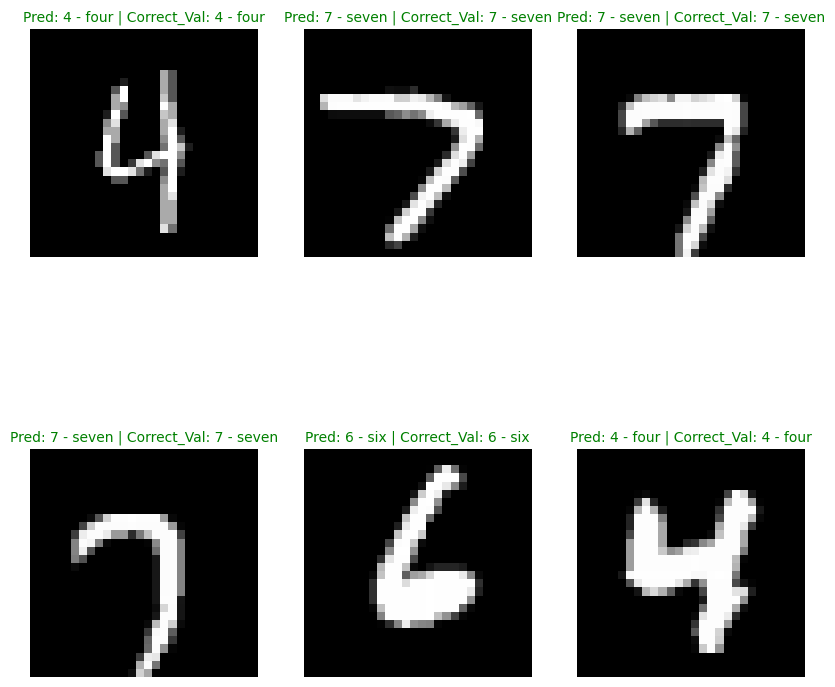

In [18]:
# Plot predictions using plt
plt.figure(figsize=(10,10))
n_rows = 2
n_cols = 3

for i, sample in enumerate(test_samps):
  plt.subplot(n_rows,n_cols,i+1)
  plt.imshow(sample.squeeze(),cmap='gray')
  # what my model predicted
  pred_label = class_names[pred_labels[i]]
  # what the correct classification is
  actual_label = class_names[test_labs[i]]
  title_text = f"Pred: {pred_label} | Correct_Val: {actual_label}"
  # Check for equality and change title colour accordingly
  if pred_label == actual_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# Saving Model

In [19]:
from pathlib import Path


MODEL_PATH = Path("DRmodels")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "DigitRecognizerV1"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # saving the models learned parameters using state_dict
           f=MODEL_SAVE_PATH)

Saving model to: DRmodels/DigitRecognizerV1
